In [39]:
import numpy as np
import trimesh
import pyrender
import os.path as osp
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import pickle

import util

/home/elchun/Documents/68301/68301_final_project/stereo-occupancy-networks/prototypes/util.py:163: SyntaxWarning:

"is not" with a literal. Did you mean "!="?



# Plotting Utils

In [32]:
def multiplot(point_list: 'list[np.ndarray]', fname='debug.html'):
    """
    Plot each group of points in {point_list} in a different color on the same
    graph and saves to {fname}.
    Args:
        point_list (list[np.ndarray]): List of pointclouds in the form
            of (n_i x 3)
        fname (str, optional): Name of file to save result to.
            Defaults to 'debug.html'.
    Returns:
        plotly plot: Plot that is produced.
    """

    plot_pts = np.vstack(point_list)

    color = np.ones(plot_pts.shape[0])

    idx = 0
    for i, pts in enumerate(point_list):
        next_idx = idx + pts.shape[0]
        color[idx:next_idx] *= (i + 1)
        idx = next_idx


    fig = px.scatter_3d()

    fig.add_trace(go.Scatter3d(
        x=plot_pts[:, 0], y=plot_pts[:, 1], z=plot_pts[:, 2],
        mode='markers',
        marker=dict(color=color, size=2)
    ))

    fig.update_layout(scene_aspectmode='data')
    # fig.update_traces(marker=dict(size=4))
    # fig.update_traces(marker=dict(size=5),
    #               selector=dict(mode='markers'))

    # fig.write_html(fname)
    # iplot(fig)

    return fig

## Load Occupancy Data
This data is extracted from the [Local Neural Descriptor Field](https://github.com/elchun/lndf_robot/) processing pipeline.  It includes raw sample coordinates and occupancy values for all the mugs, bowls, and bottles.

Ultimately, we can load the shapenet meshes as well, then transform both the occupancy values and meshes as desired.


In [2]:
shapenet_categories = {'mug': '03797390',
    'bowl': '02880940',
    'bottle': '02876657'}

shapenet_id = '1eaf8db2dd2b710c7d5b1b70ae595e60'

data_dir = "../data"
mug_occ_dict = pickle.load(open(osp.join(data_dir,
    'training_data/occ_shapenet_mug.p'), "rb"))

In [3]:
voxel_path = osp.join(shapenet_categories['mug'], shapenet_id, 'models', 'model_normalized_128.mat')
coord, voxel_bool, _ = mug_occ_dict[voxel_path]

In [4]:
print(coord.shape)
print(voxel_bool.shape)
pos_coord = coord[voxel_bool[:, 0], :]
print(pos_coord.shape)

(100000, 3)
(100000, 1)
(8347, 3)


In [5]:
# -- Plot with plotly -- #
init_notebook_mode(connected=True)         # initiate notebook for offline plot

fig = px.scatter_3d()

fig.add_trace(go.Scatter3d(
    x=pos_coord[:, 0], y=pos_coord[:, 1], z=pos_coord[:, 2],
    mode='markers', 
    marker=dict(color='rgba(255, 106, 100, 1.0)', size=1)
))
fig.update_layout(scene_aspectmode='data')
iplot(fig)

# Load Mesh
From: https://pyrender.readthedocs.io/en/latest/examples/quickstart.html

In [17]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

Note that the query points and shapenet object are aligned.  Remember to transform them together when applying data augmentations.

In [35]:
demo_cup = trimesh.load(osp.join(data_dir, 'objects/mug_centered_obj/', shapenet_id, 'models/model_128_df.obj'))
demo_cup_pcd = demo_cup.sample(500)

fig = multiplot([pos_coord, demo_cup_pcd])
iplot(fig)


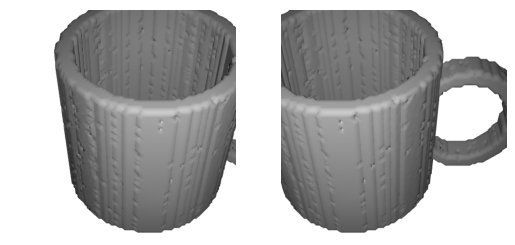

In [65]:
# https://pyrender.readthedocs.io/en/latest/examples/offscreen.html
# TODO: Calculate camera intrinsics

demo_cup = trimesh.load(osp.join(data_dir, 'objects/mug_centered_obj/', shapenet_id, 'models/model_128_df.obj'))
rot1 = np.eye(4)
rot1[:3, :3] = util.make_rotation_matrix('x', np.pi / 2)
demo_cup.apply_transform(rot1)

mesh = pyrender.Mesh.from_trimesh(demo_cup)

scene_l = pyrender.Scene()
scene_r = pyrender.Scene()

scene_l.add(mesh)
scene_r.add(mesh)

# Perspective camera is prob more realistic
camera_l = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
camera_r = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)

# # Orthographic camera may be easier to deal with
# camera_l = pyrender.OrthographicCamera(xmag=1.0, ymag=1.0)
# camera_r = pyrender.OrthographicCamera(xmag=1.0, ymag=1.0)

s = np.sqrt(2)/2
center_offset = 0.1
camera_l_pose = np.array([
    [0.0, -s,   s,   0.9],
    [1.0,  0.0, 0.0, -center_offset],
    [0.0,  s,   s,   0.9],
    [0.0,  0.0, 0.0, 1.0],
])
camera_r_pose = np.array([
    [0.0, -s,   s,   0.9],
    [1.0,  0.0, 0.0, center_offset],
    [0.0,  s,   s,   0.9],
    [0.0,  0.0, 0.0, 1.0],
])
scene_l.add(camera_l, pose=camera_l_pose)
scene_r.add(camera_r, pose=camera_r_pose)

light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,
                            innerConeAngle=np.pi/16.0,
                            outerConeAngle=np.pi/6.0)

scene_l.add(light, pose=camera_l_pose)
scene_l.add(light, pose=camera_r_pose)

scene_r.add(light, pose=camera_l_pose)
scene_r.add(light, pose=camera_r_pose)

r = pyrender.OffscreenRenderer(400, 400)
color_l, depth_l = r.render(scene_l)
color_r, depth_r = r.render(scene_r)
r.delete()  # Close the renderer to prevent EGL error

plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color_l)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(color_r)
# plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()
